# Transfer Learning with Tensorflow: Fine-tuning

In [1]:
!nvidia-smi

Thu Apr 11 13:43:58 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import tensorflow as tf

##  Creating (Importing) helper functions

In [3]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-04-11 13:44:03--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-04-11 13:44:04 (58.8 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:
# Import helper functions we are going to use
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

## Let's get some data

This time we're going to see how we can use the pretrained models within `tf.keras.application`

In [5]:
# Get 10 % of train data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2024-04-11 13:44:05--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.218.207, 142.251.31.207, 142.250.153.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.218.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  36.6MB/s    in 5.0s    

2024-04-11 13:44:10 (32.5 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [6]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent

In [7]:
# Create train- and test paths
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [8]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data = image_dataset_from_directory(
    train_dir,
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
)

test_data = image_dataset_from_directory(
    test_dir,
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [9]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [10]:
# Check out class names
train_data.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [11]:
for images, labels in train_data.take(1):
  print(images, labels)

tf.Tensor(
[[[[3.53325920e+01 2.53325882e+01 2.33325882e+01]
   [3.10000000e+01 2.30000000e+01 2.10000000e+01]
   [3.18571434e+01 2.70714302e+01 2.40714302e+01]
   ...
   [3.63816299e+01 1.79039516e+01 1.10622587e+01]
   [3.44776802e+01 1.60000000e+01 8.73883915e+00]
   [3.31205025e+01 1.46428223e+01 7.38166142e+00]]

  [[3.60714302e+01 2.60714283e+01 2.40714283e+01]
   [3.10559635e+01 2.30559635e+01 2.10559635e+01]
   [3.10736618e+01 2.62879486e+01 2.32879486e+01]
   ...
   [3.40758286e+01 1.86427917e+01 1.19785357e+01]
   [3.13770618e+01 1.59440269e+01 8.72750854e+00]
   [2.92923756e+01 1.38593407e+01 6.64282227e+00]]

  [[3.71806450e+01 2.71806450e+01 2.51806450e+01]
   [3.10932713e+01 2.30932713e+01 2.10932713e+01]
   [3.07916145e+01 2.60059013e+01 2.30059013e+01]
   ...
   [3.33369865e+01 2.07998543e+01 1.59887314e+01]
   [2.92951031e+01 1.69067116e+01 1.15183191e+01]
   [2.59219875e+01 1.35335960e+01 8.14520359e+00]]

  ...

  [[8.30549011e+01 4.00549049e+01 5.69776201e+00]
   [6

## Building a transfer learning model using the Keras Functional API

The sequential API is straight-forward, it runs our layers in sequential order.

But the functional API gives us more flexibility for our models

In [12]:
# 1. Create base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=IMG_SIZE+(3,), name="input_layer")

# 4. If using a model like ResNet50V2 you need to normolize inputs
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1/255.)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)

# 6. Average pool the outputs of the base model
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs and outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

model_0.compile(
    optimizer="Adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

16705208/16705208 [==============================] - 1s 0us/step


In [13]:
history_0 = model_0.fit(train_data,
          epochs=5,
          steps_per_epoch=len(train_data),
          validation_data=test_data,
          validation_steps=len(test_data))

Epoch 1/5
24/24 [==============================] - 21s 453ms/step - loss: 1.8990 - accuracy: 0.4253 - val_loss: 1.3239 - val_accuracy: 0.7140
Epoch 2/5
24/24 [==============================] - 8s 313ms/step - loss: 1.1160 - accuracy: 0.7600 - val_loss: 0.8833 - val_accuracy: 0.8080
Epoch 3/5
24/24 [==============================] - 7s 274ms/step - loss: 0.7980 - accuracy: 0.8267 - val_loss: 0.7048 - val_accuracy: 0.8408
Epoch 4/5
24/24 [==============================] - 8s 303ms/step - loss: 0.6493 - accuracy: 0.8480 - val_loss: 0.6125 - val_accuracy: 0.8516
Epoch 5/5
24/24 [==============================] - 8s 315ms/step - loss: 0.5592 - accuracy: 0.8640 - val_loss: 0.5590 - val_accuracy: 0.8612


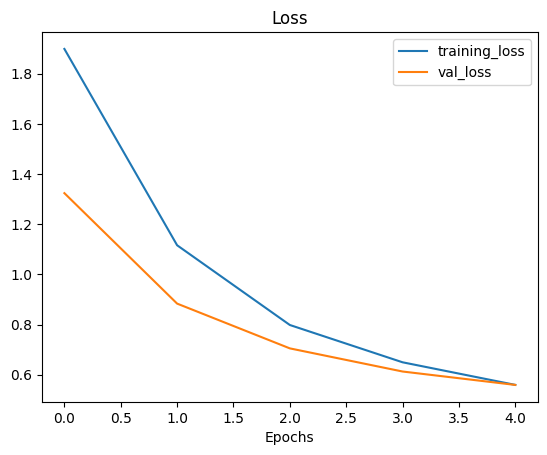

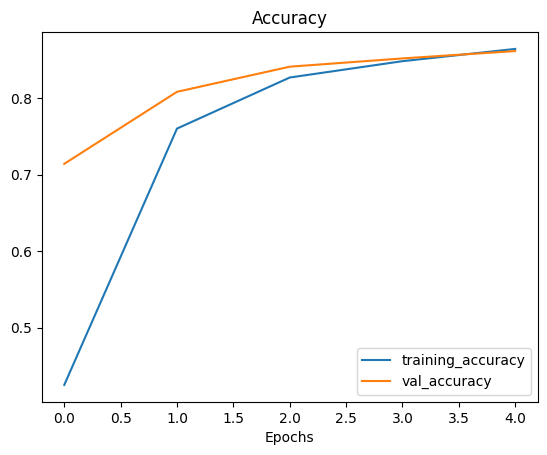

In [14]:
plot_loss_curves(history_0)

In [15]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062381 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049571 (15.45 MB)
__________________

In [16]:
# Evaluate a model
model_0.evaluate(test_data)

79/79 [==============================] - 8s 91ms/step - loss: 0.5590 - accuracy: 0.8612


[0.5590446591377258, 0.8611999750137329]

In [17]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 rescaling_1
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activation
5

In [18]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, None, None, 3)        7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, None, None, 3)        0         ['normalization[0

## Getting a feature vector from a trained model

Let's demonstrate the Global Average Pooling 2D layer...

We have a tensor after our model goes through `base_model` of shape (None, 7, 7, 1280).

But when it passes through GlobalAveragePooling2D, it turns into (None, 1280).

Let's use a similar shaped tensor of (1, 4, 4, 3) and then pass it to GlobalAveragePooling2D.





In [19]:
# Define the input shape
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338894  0.97772694]
   [ 0.24694404  0.20573746 -0.52562326]
   [ 0.32410017  0.02545409 -0.10638496]
   [-0.63694745  1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815628  0.23479679 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]



In [20]:
# Pass the random tensor through GlobalAveragePooling2D
global_average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)

In [21]:
global_average_pooling_layer

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

In [22]:
# Let's replicate the GlobalAveragePooling2D
tf.reduce_mean(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

In [23]:
tf.constant([[tf.reduce_mean(input_tensor[:, :, :, i]).numpy() for i in range(0, input_tensor.shape[-1])]])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368647, -0.45840448, -0.2885598 ]], dtype=float32)>

## Running a series of transfer learning experiments

We've seen the incredible results transfer learning can get with only 10% of the training data, but now does it go with 1% of the training data... how about we set up a bunch of experiments to find out:

1. `model_1` - use feature extraction transfer learning with 1% of the training data with data augmentation
2. `model_2` - use feature extraction transfer learning with 10% of the training with data augmentation
3. `model_3` - use fine-tuning transfer learning transfer learning on 10% of the training data with data augmentation
4. `model_4` - use fine-tuning transfer learning on 100% of the training data with data augmentation

> **Note:** throughoout all experiments the same test dataset will be used to evaluate our model... this ensures consistency acrosss evaluation metrics.

## Getting and preprocesing data for model_1

In [24]:
# Download and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

--2024-04-11 13:45:42--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.96.207, 108.177.119.207, 108.177.127.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.96.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  29.4MB/s    in 4.9s    

2024-04-11 13:45:47 (26.3 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [25]:
# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir_1_percent  = "10_food_classes_1_percent/test"

In [26]:
# How many images are we working with?
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There a

In [27]:
# Setup data loaders
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir_1_percent,
    label_mode="categorical",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir_1_percent,
    label_mode="categorical",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into the model

To add data augmemntation right into our models, we can use the layers inside:
* `tf.keras.layers.experimental.preprocessing()`

In [28]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmentation
data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    # preprocessing.Rescale(1./255)
], name="data_augmentation")

### Visualize our data augmentation layer and see what happens to our data

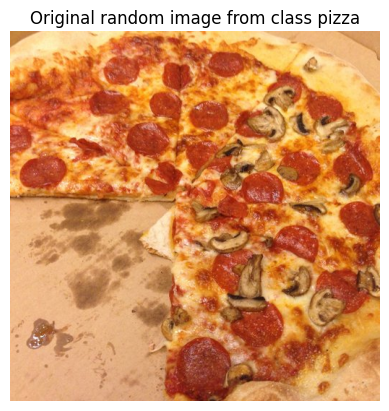

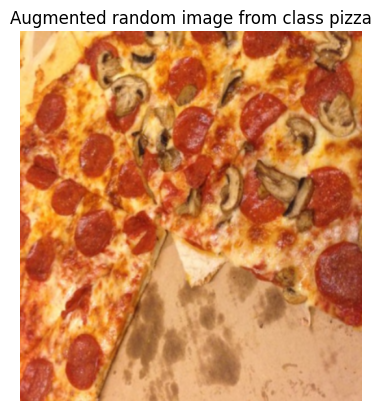

In [29]:
 # View a random image and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# Read and plot the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.axis(False)
plt.title(f"Original random image from class {target_class}")

# Plot augmented random image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0), training=True)
plt.figure()
plt.axis(False)
plt.title(f"Augmented random image from class {target_class}")
plt.imshow(tf.squeeze(augmented_img)/255);

In [30]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape)

# Add in data augmentation as a Sequential mode as a layer
x = data_augmentation(inputs)

# Give base model augmented data
x = base_model(x, training=False)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D()(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax", name="output")(x)

# Make a model
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(
    optimizer="Adam",
    loss="categorical_crossentropy",
    metrics="accuracy"
)

# Fit the model
history_1 = model_1.fit(
    train_data_1_percent,
    epochs=5,
    steps_per_epoch=len(train_data_1_percent),
    validation_data=test_data,
    validation_steps=len(test_data)
)

Epoch 1/5
3/3 [==============================] - 16s 4s/step - loss: 2.3218 - accuracy: 0.0714 - val_loss: 2.2252 - val_accuracy: 0.1792
Epoch 2/5
3/3 [==============================] - 9s 4s/step - loss: 2.1041 - accuracy: 0.2000 - val_loss: 2.0981 - val_accuracy: 0.2720
Epoch 3/5
3/3 [==============================] - 13s 6s/step - loss: 1.9133 - accuracy: 0.3571 - val_loss: 1.9871 - val_accuracy: 0.3504
Epoch 4/5
3/3 [==============================] - 8s 4s/step - loss: 1.7487 - accuracy: 0.5571 - val_loss: 1.8882 - val_accuracy: 0.4096
Epoch 5/5
3/3 [==============================] - 7s 3s/step - loss: 1.5976 - accuracy: 0.6571 - val_loss: 1.8015 - val_accuracy: 0.4536


In [31]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 output (Dense)              (None, 10)                12810     
                                                           

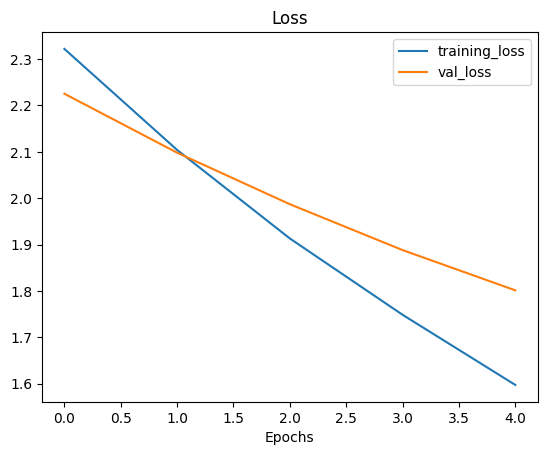

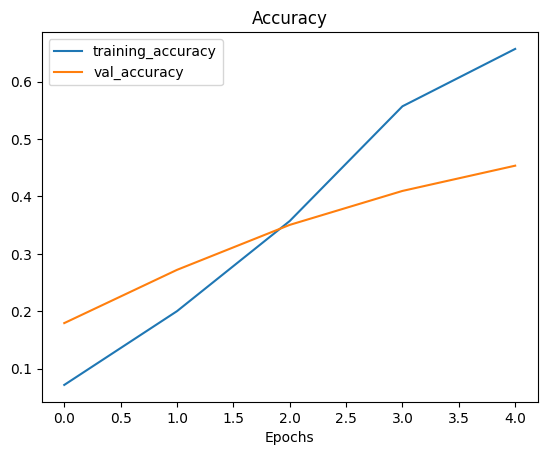

In [32]:
plot_loss_curves(history_1)

## Model 2: feature extraction transfer learning model with 10% of data and data augmentation

In [33]:
# 10 percent, augmentation
data_augmentation = keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
    tf.keras.layers.experimental.preprocessing.RandomWidth(0.2)
])

INPUT_SHAPE = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = tf.keras.layers.Input(INPUT_SHAPE)

x = data_augmentation(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)

outputs = tf.keras.layers.Dense(10, activation="softmax", name="output")(x)

model_2 = tf.keras.Model(inputs, outputs)

model_2.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.categorical_crossentropy,
    metrics=["accuracy"]
)

### Creating a ModelCheckpoint callback

The ModelCheckpoint callback intermediately saves our model (the full model or just the weights) during training. This is useful so we can come and start where we left off.

In [34]:
# Set the checkpoint path
checkpoint_path = '/tmp/ckpt/checkpoint.weights.h5'

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_the_weights_only=True,
    save_the_best_only=True,
    save_freq="epoch",
    verbose=1
)

In [35]:
history_2 = model_2.fit(
    train_data,
    epochs=5,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=len(test_data),
    callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                           experiment_name="10_percenent_data_aug"),
               checkpoint_callback]
)

Saving TensorBoard log files to: transfer_learning/10_percenent_data_aug/20240411-134655
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.9723 - accuracy: 0.3653
Epoch 1: saving model to /tmp/ckpt/checkpoint.weights.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 36s 1s/step - loss: 1.9723 - accuracy: 0.3653 - val_loss: 1.4197 - val_accuracy: 0.6760
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.2916 - accuracy: 0.7067
Epoch 2: saving model to /tmp/ckpt/checkpoint.weights.h5
24/24 [==============================] - 23s 930ms/step - loss: 1.2916 - accuracy: 0.7067 - val_loss: 0.9827 - val_accuracy: 0.7776
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 0.9860 - accuracy: 0.7640
Epoch 3: saving model to /tmp/ckpt/checkpoint.weights.h5
24/24 [==============================] - 20s 812ms/step - loss: 0.9860 - accuracy: 0.7640 - val_loss: 0.7840 - val_accuracy: 0.8188
Epoch 4/5
24/24 [==============================] - ETA: 0s - loss: 0.8194 - accuracy: 0.8000
Epoch 4: saving model to /tmp/ckpt/checkpoint.weights.h5
24/24 [==============================] - 20s 826ms/step - loss: 0.8194 - accuracy: 0.8000 - val_loss: 0.6842 - val_accuracy: 0.8296
Epoch 5/5
24/24 [========

In [36]:
model_2.evaluate(test_data)
 # globalAveragePooling2d [0.6201287508010864, 0.8452000021934509]
# globalMaxPooling2d     [0.6133595108985901, 0.8515999913215637]

79/79 [==============================] - 6s 64ms/step - loss: 0.6274 - accuracy: 0.8364


[0.6274372935295105, 0.8363999724388123]

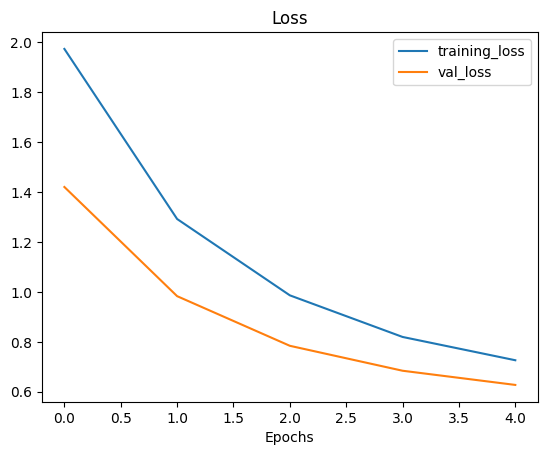

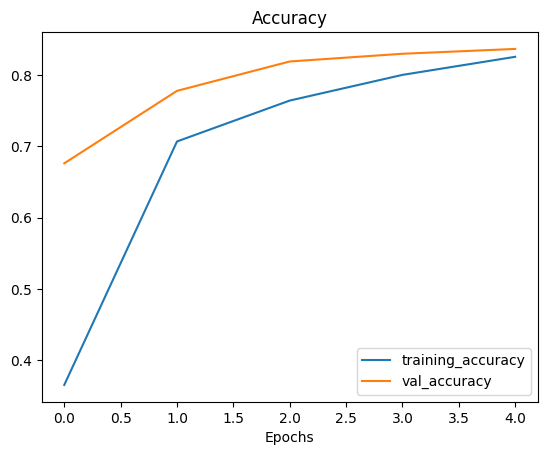

In [37]:
plot_loss_curves(history_2)

### Loading in checkpointed weights

Loading in checkpointed weights returns a model to a specific checkpoint.

In [38]:
results = model_2.evaluate(test_data)

79/79 [==============================] - 6s 73ms/step - loss: 0.6274 - accuracy: 0.8364


In [39]:
# Load in saved modek weights and evaluate model
# model_2.load_weights('/tmp/ckpt/checkpoint.weights.h5')

In [40]:
#model_2.load_weights(checkpoint_path)

In [41]:
#checkpoint_path

In [42]:
# Check if loaded results re very close to previous
import numpy as np
np.isclose(np.array(results), np.array(model_2.evaluate(test_data)))

79/79 [==============================] - 6s 75ms/step - loss: 0.6274 - accuracy: 0.8364


array([ True,  True])

## Model 3: Fine-tuning an existing model on 10% of the data

**Note:** Fine-tuning usually works best *afer* training a feature extraction model for a few epochs with large amounts of custom data.

In [43]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling2d_2  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 output (Dense)              (None, 10)                12810     
                                                                 
Total params: 4062381 (15.50 MB)
Trainable params: 12810 (5

In [44]:
model_2.layers

In [45]:
# Are these layers trainable?
for layer in model_2.layers:
  print(layer, layer.trainable)

<keras.src.engine.input_layer.InputLayer object at 0x7ef14cbbba90> True
<keras.src.engine.sequential.Sequential object at 0x7ef14bfb6380> True
<keras.src.engine.functional.Functional object at 0x7ef14bcae9b0> False
<keras.src.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7ef14bb19240> True
<keras.src.layers.core.dense.Dense object at 0x7ef14bb37820> True


In [46]:
# Layers in EfficientNetB0 and are there trainable
for i, layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_4 False
1 rescaling_4 False
2 normalization_2 False
3 rescaling_5 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [47]:
# How many trainable variables are in our base model?
print(len(model_2.layers[0].trainable_variables))

0


In [48]:
# To begin fine-tuning lets set last 10 layers of our base model to true
base_model.trainable = True

# Freeze all layers except last 10
for layer in base_model.layers[:-10]:
  layer.trainable=False
  print(layer.name)

# Recompile a model every time we make a change to a model
model_2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.categorical_crossentropy,
    metrics=["accuracy"]
)

input_4
rescaling_4
normalization_2
rescaling_5
stem_conv_pad
stem_conv
stem_bn
stem_activation
block1a_dwconv
block1a_bn
block1a_activation
block1a_se_squeeze
block1a_se_reshape
block1a_se_reduce
block1a_se_expand
block1a_se_excite
block1a_project_conv
block1a_project_bn
block2a_expand_conv
block2a_expand_bn
block2a_expand_activation
block2a_dwconv_pad
block2a_dwconv
block2a_bn
block2a_activation
block2a_se_squeeze
block2a_se_reshape
block2a_se_reduce
block2a_se_expand
block2a_se_excite
block2a_project_conv
block2a_project_bn
block2b_expand_conv
block2b_expand_bn
block2b_expand_activation
block2b_dwconv
block2b_bn
block2b_activation
block2b_se_squeeze
block2b_se_reshape
block2b_se_reduce
block2b_se_expand
block2b_se_excite
block2b_project_conv
block2b_project_bn
block2b_drop
block2b_add
block3a_expand_conv
block3a_expand_bn
block3a_expand_activation
block3a_dwconv_pad
block3a_dwconv
block3a_bn
block3a_activation
block3a_se_squeeze
block3a_se_reshape
block3a_se_reduce
block3a_se_expand

In [49]:
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_4 False
1 rescaling_4 False
2 normalization_2 False
3 rescaling_5 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

> **Note:** when fine-tuning you typically want to lower the learning rate by 10x

In [50]:
len(model_2.layers[2].trainable_variables)

10

In [51]:
# Fine-tune for another 5 epochs
initial_epochs = 5
fine_tune_epochs = initial_epochs + 5

# Refit the model
history_fine_10_percent_data_aug = model_2.fit(
  train_data,
  epochs=fine_tune_epochs,
  validation_data=test_data,
  validation_steps=len(test_data),
  initial_epoch=history_2.epoch[-1], # start training from previous last epoch
  callbacks=[checkpoint_callback]
)

Epoch 5/10
24/24 [==============================] - ETA: 0s - loss: 0.6206 - accuracy: 0.8187
Epoch 5: saving model to /tmp/ckpt/checkpoint.weights.h5
24/24 [==============================] - 32s 944ms/step - loss: 0.6206 - accuracy: 0.8187 - val_loss: 0.4898 - val_accuracy: 0.8512
Epoch 6/10
24/24 [==============================] - ETA: 0s - loss: 0.5056 - accuracy: 0.8453
Epoch 6: saving model to /tmp/ckpt/checkpoint.weights.h5
24/24 [==============================] - 18s 734ms/step - loss: 0.5056 - accuracy: 0.8453 - val_loss: 0.4670 - val_accuracy: 0.8496
Epoch 7/10
24/24 [==============================] - ETA: 0s - loss: 0.4290 - accuracy: 0.8827
Epoch 7: saving model to /tmp/ckpt/checkpoint.weights.h5
24/24 [==============================] - 19s 773ms/step - loss: 0.4290 - accuracy: 0.8827 - val_loss: 0.4434 - val_accuracy: 0.8600
Epoch 8/10
24/24 [==============================] - ETA: 0s - loss: 0.3920 - accuracy: 0.8960
Epoch 8: saving model to /tmp/ckpt/checkpoint.weights.h5


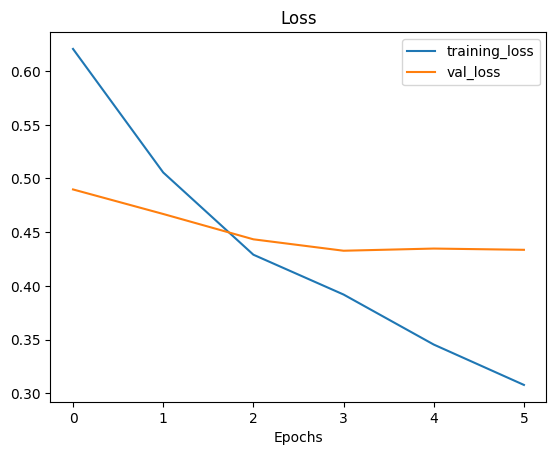

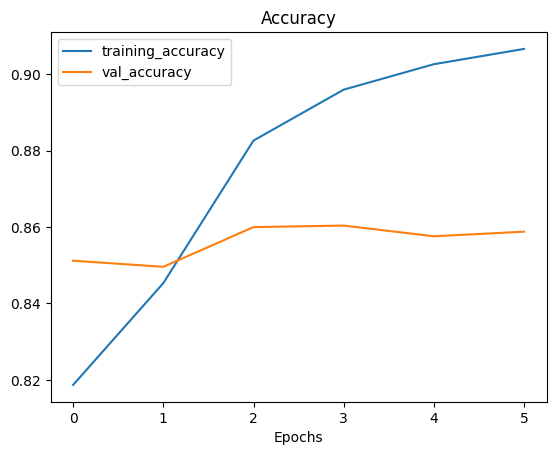

In [52]:
plot_loss_curves(history_fine_10_percent_data_aug)

The `plot_loss_curves` functions works great with models which have only been fit once, however, we want smth to compare one series of running `fit()` wit another (e.g. before and after fine-tuning).

In [53]:
# Let's create a f+unc to compare training histories
def compare_histories(original_history, new_history, initial_epochs=5):
  """
  Compares two TF History objects.
  """
  # Get original history measurements
  acc = original_history.history["accuracy"]
  loss = original_history.history["loss"]

  val_acc = original_history.history["val_accuracy"]
  val_loss = original_history.history["val_loss"]

  # Combine original history with new_history
  total_acc = acc + new_history.history["accuracy"]
  total_loss = loss + new_history.history["loss"]

  total_val_acc = val_acc + new_history.history["val_accuracy"]
  total_val_loss = val_loss + new_history.history["val_loss"]

  # Make plots for acc
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(total_acc, label="Training Accuracy")
  plt.plot(total_val_acc, label="Validation Accuracy")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start fine-tuning")
  plt.legend(loc="lower right")
  plt.title("Training and validation accuracy")

  # Make plots for loss
  plt.figure(figsize=(8,8))
  plt.subplot(2, 1, 1)
  plt.plot(total_loss, label="Training Loss")
  plt.plot(total_val_loss, label="Validation Loss")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start fine-tuning")
  plt.legend(loc="upper right")
  plt.title("Training and validation loss")

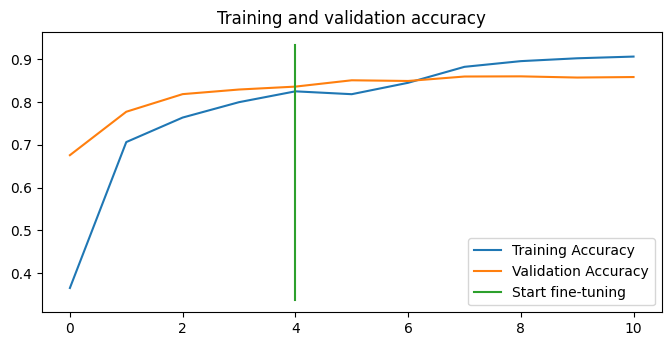

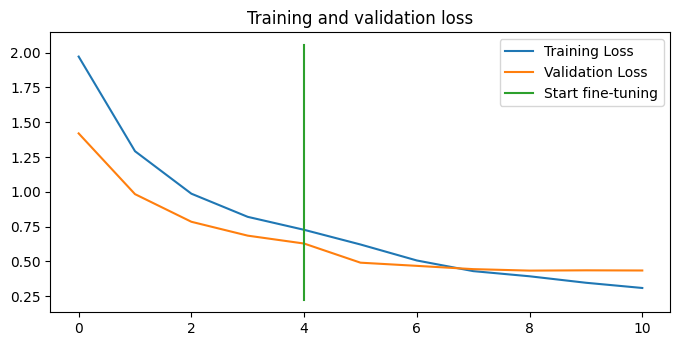

In [54]:
compare_histories(history_2, history_fine_10_percent_data_aug)

## Model 4: Fine tuning on full train data

In [56]:
# Download dataset
! wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

--2024-04-11 13:54:52--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.145.207, 74.125.128.207, 74.125.143.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.145.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  40.8MB/s    in 13s     

2024-04-11 13:55:05 (38.6 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [57]:
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.

In [73]:
train_dir_all_data = "10_food_classes_all_data/train"
test_dir = "10_food_classes_all_data/test"

In [74]:
# Turn into dataset
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_all = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir_all_data,
    label_mode="categorical",
    image_size=IMG_SIZE
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode="categorical",
    image_size=IMG_SIZE
)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [65]:
# Create model_4
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
    tf.keras.layers.experimental.preprocessing.RandomWidth(0.2)
])

INPUT_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = tf.keras.layers.Input(INPUT_SHAPE)

x = data_augmentation(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)

outputs = tf.keras.layers.Dense(10, activation="softmax")(x)

model_4 = tf.keras.Model(inputs, outputs)

In [68]:
train_dir

'10_food_classes_10_percent/train'

тут короче виходить, що коли було 10% то я зберіг як `train_data`/`test_data` і вона перезаписалась тому спочатку перезаписуємо ще раз на 10%

In [90]:
model_4.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.categorical_crossentropy,
    metrics=['accuracy']
)

history_4 = model_4.fit(
    train_data,
    steps_per_epoch=len(train_data),
    epochs=5,
    validation_data=test_data,
    validation_steps=len(test_data)
)

Epoch 1/5
24/24 [==============================] - 23s 558ms/step - loss: 0.1632 - accuracy: 0.9453 - val_loss: 0.3041 - val_accuracy: 0.9164
Epoch 2/5
24/24 [==============================] - 11s 450ms/step - loss: 0.0553 - accuracy: 0.9853 - val_loss: 0.3324 - val_accuracy: 0.9100
Epoch 3/5
24/24 [==============================] - 11s 442ms/step - loss: 0.0362 - accuracy: 0.9907 - val_loss: 0.2699 - val_accuracy: 0.9216
Epoch 4/5
24/24 [==============================] - 13s 521ms/step - loss: 0.0263 - accuracy: 0.9907 - val_loss: 0.3462 - val_accuracy: 0.9128
Epoch 5/5
24/24 [==============================] - 12s 498ms/step - loss: 0.0343 - accuracy: 0.9867 - val_loss: 0.3175 - val_accuracy: 0.9164


In [91]:
# To begin fine-tuning lets set last 10 layers of our base model to true
base_model.trainable = True

# Freeze all layers except last 10
for layer in base_model.layers[:-10]:
  layer.trainable=False

# Recompile a model every time we make a change to a model
model_4.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.categorical_crossentropy,
    metrics=["accuracy"],
)

In [92]:
# Fine-tune on 100% per cent of the data
fine_tune_epochs = 10

history_4_fine_tune = model_4.fit(
    train_data_all,
    epochs=fine_tune_epochs,
    steps_per_epoch=len(train_data_all),
    validation_data=test_data,
    validation_steps=len(test_data),
    initial_epoch=history_4.epoch[-1]
)

Epoch 5/10
235/235 [==============================] - 65s 241ms/step - loss: 0.1799 - accuracy: 0.9373 - val_loss: 0.3177 - val_accuracy: 0.9052
Epoch 6/10
235/235 [==============================] - 51s 214ms/step - loss: 0.1436 - accuracy: 0.9508 - val_loss: 0.3285 - val_accuracy: 0.9084
Epoch 7/10
235/235 [==============================] - 49s 206ms/step - loss: 0.1297 - accuracy: 0.9568 - val_loss: 0.3181 - val_accuracy: 0.9136
Epoch 8/10
235/235 [==============================] - 48s 202ms/step - loss: 0.1164 - accuracy: 0.9601 - val_loss: 0.3273 - val_accuracy: 0.9116
Epoch 9/10
235/235 [==============================] - 47s 200ms/step - loss: 0.1055 - accuracy: 0.9636 - val_loss: 0.3776 - val_accuracy: 0.9020
Epoch 10/10
235/235 [==============================] - 42s 175ms/step - loss: 0.1090 - accuracy: 0.9640 - val_loss: 0.3732 - val_accuracy: 0.9104


In [93]:
model_4.evaluate(test_data)

79/79 [==============================] - 6s 76ms/step - loss: 0.3732 - accuracy: 0.9104


[0.37322211265563965, 0.9103999733924866]

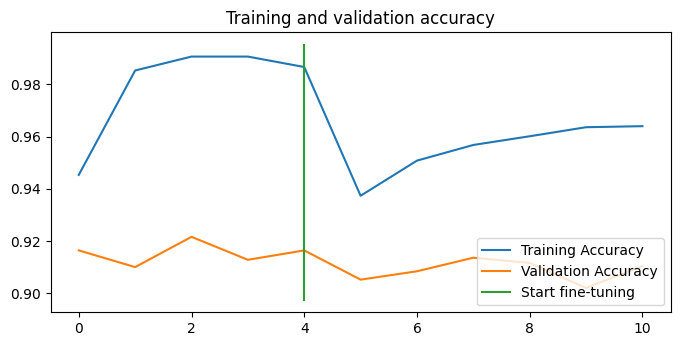

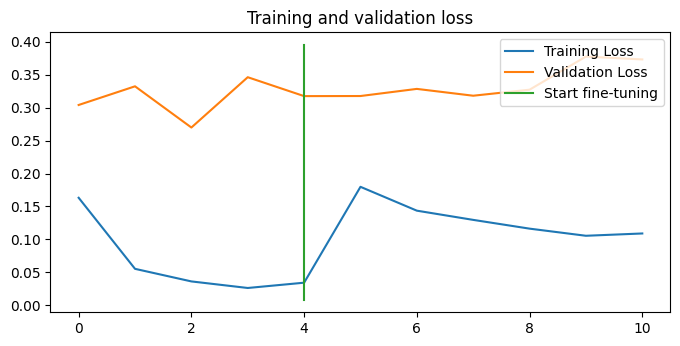

In [94]:
# How did fine-tuning go with more data?
compare_histories(history_4, history_4_fine_tune)

{'loss': [0.6988649964332581,
  0.30608275532722473,
  0.2096373438835144,
  0.15697067975997925,
  0.08554118126630783],
 'accuracy': [0.781333327293396,
  0.9133333563804626,
  0.9319999814033508,
  0.9413333535194397,
  0.9786666631698608]}